Tranformer Models

In [112]:
import os
import pickle
import numpy as np
import torch
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from scipy.integrate import simps
from torch_geometric.data import Data

# Set your dataset path
dataset_path = "/Users/kostasbekis/Emotion_detection/Deap_dataset/deap/data_preprocessed_python"

# Get all .dat files
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".dat")]

# Load dataset
all_data, all_labels = [], []
for file in all_files:
    with open(file, 'rb') as f:
        file_data = pickle.load(f, encoding='latin1')
        all_data.append(file_data['data'])  # EEG data shape (40, 8064)
        all_labels.append(file_data['labels'])  # Labels shape (4,)

# Convert lists to NumPy arrays
labels = np.array(all_labels).reshape(-1, 4)  # Shape (1280, 4)
data = np.array(all_data).reshape(-1, 40, 8064)  # Shape (1280, 40, 8064)

# Use only the first 32 EEG channels
eeg_data = data[:, :32, :]

print("EEG Data Shape:", eeg_data.shape)  # (1280, 32, 8064)
print("Labels Shape:", labels.shape)  # (1280, 4)


EEG Data Shape: (1280, 32, 8064)
Labels Shape: (1280, 4)


In [113]:
# Function to calculate statistical features
def calculate_statistical_features(data):
    return np.column_stack([
        np.mean(data, axis=1),
        np.std(data, axis=1),
        kurtosis(data, axis=1),
        skew(data, axis=1)
    ])

# Apply feature extraction to each EEG channel
eeg_stat_features = np.hstack([
    calculate_statistical_features(eeg_data[:, i, :]) for i in range(eeg_data.shape[1])
])

print("EEG Statistical Features Shape:", eeg_stat_features.shape)  # (1280, 128)


EEG Statistical Features Shape: (1280, 128)


In [114]:
# EEG Frequency Bands
FREQ_BANDS = {"delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 64)}

def bandpower(data, sf, band):
    low, high = band
    freqs, psd = welch(data, sf, nperseg=int(2 * sf / low))
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[idx_band], dx=freqs[1] - freqs[0])

# Compute power for each band
eeg_band_features = np.hstack([
    np.array([[bandpower(eeg_data[i, j], 128, FREQ_BANDS[band]) for band in FREQ_BANDS] 
              for j in range(eeg_data.shape[1])]).flatten()
    for i in range(eeg_data.shape[0])
])

# Reshape to (1280, 160)
eeg_band_features = eeg_band_features.reshape(1280, -1)

print("EEG Band Power Features Shape:", eeg_band_features.shape)  # (1280, 160)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_29952/1947442904.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(psd[idx_band], dx=freqs[1] - freqs[0])


EEG Band Power Features Shape: (1280, 160)


In [115]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------------------------------------------
# 1. Normalize EEG features
# ----------------------------------------------------------------
# Assuming `eeg_band_features` is your feature tensor 
# and `labels` is the emotion label tensor (shape: [1280, 4])
scaler = StandardScaler()
eeg_data_normalized = scaler.fit_transform(eeg_band_features)  # Normalize across the dataset

# Convert to PyTorch tensors
features_tensor = torch.tensor(eeg_data_normalized, dtype=torch.float32)  # Shape: (1280, 160)

# ----------------------------------------------------------------
# 2. Create multi-class labels (binary for each emotion dimension)
# ----------------------------------------------------------------
threshold = np.median(labels, axis=0)  # median for each emotion dimension
labels_multiclass = (labels > threshold).astype(int)  # 0/1 for each emotion

# Convert labels to PyTorch tensor (multi-label, shape: [1280, 4])
single_label_array = np.argmax(labels_multiclass, axis=1)  # shape (N,)

labels_tensor = torch.tensor(single_label_array, dtype=torch.long)  # shape: (N,)


# ----------------------------------------------------------------
# 3. Train / Validation / Test Split
#    (Example: 60% train, 20% val, 20% test)
# ----------------------------------------------------------------
total_samples = len(features_tensor)
train_size = int(0.8 * total_samples)   # 80%
val_size   = int(0.1 * total_samples)   # 10%
test_size  = total_samples - train_size - val_size

# Indices for each subset
train_end_idx = train_size
val_end_idx = train_size + val_size

# Slice features and labels into train/val/test
train_data = features_tensor[:train_end_idx]
train_labels = labels_tensor[:train_end_idx]

val_data = features_tensor[train_end_idx:val_end_idx]
val_labels = labels_tensor[train_end_idx:val_end_idx]

test_data = features_tensor[val_end_idx:]
test_labels = labels_tensor[val_end_idx:]

# ----------------------------------------------------------------
# 4. Create Datasets & Dataloaders
# ----------------------------------------------------------------
train_dataset = TensorDataset(train_data, train_labels)
val_dataset   = TensorDataset(val_data,   val_labels)
test_dataset  = TensorDataset(test_data,  test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# Now you have train_loader, val_loader, and test_loader.
# You can train your model on train_loader, tune hyperparameters on val_loader,
# and finally evaluate on test_loader.


In [116]:
class EEGTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads=8, num_layers=6):
        super(EEGTransformer, self).__init__()

        # Linear layer to project input_dim (e.g., 160) to hidden_dim (e.g., 128)
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # IMPORTANT: Use batch_first=True so the shape is (batch, seq_len, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers
        )

        # Final classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, input_dim)   # Example: (64, 160)
        We add a dummy sequence dimension so it becomes (batch_size, 1, input_dim).
        """
        # Add a dummy time dimension of size 1
        x = x.unsqueeze(1)  # -> (batch_size, 1, input_dim)

        # Project to (batch_size, 1, hidden_dim)
        x = self.input_projection(x)
        print(f"Shape after input projection: {x.shape}")

        # Pass through Transformer
        x = self.transformer_encoder(x)   # (batch_size, 1, hidden_dim)
        print(f"Shape after transformer: {x.shape}")

        # Since we only have 1 time step, mean-pooling across dim=1
        # is effectively the same as x.squeeze(1)
        x = x.mean(dim=1)                 # (batch_size, hidden_dim)
        print(f"Shape after pooling: {x.shape}")

        # Classify
        x = self.fc(x)                    # (batch_size, num_classes)
        return x


In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



model = EEGTransformer(input_dim=160, hidden_dim=128, num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Example train_loader with data of shape [64, 160]
train_loader = [
    (torch.randn(64, 160), torch.randint(0, 4, (64,))) for _ in range(10)
]

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)             # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        
        loss.backward()                   # Backprop
        optimizer.step()
        
        total_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {total_loss/len(train_loader):.4f}, "
          f"Accuracy: {correct/total:.4f}")


Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape a

In [118]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, device):
    model.eval()  # evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            # If your labels are one-hot, convert them to indices:
            if labels.dim() == 2 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            outputs = model(data)
            _, predicted = torch.max(outputs, dim=1)  # shape: (batch,)
            
            # Collect
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Flatten arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Debug check (optional)
    # print("all_preds shape:", all_preds.shape)
    # print("all_labels shape:", all_labels.shape)
    # print("unique preds:", np.unique(all_preds))
    # print("unique labels:", np.unique(all_labels))
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    return cm


Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Shape after input projection: torch.Size([64, 1, 128])
Shape after transformer: torch.Size([64, 1, 128])
Shape after pooling: torch.Size([64, 128])
Confusion Matrix:
 [[12 39  0 16]
 [ 6 28  0  6]
 [ 7  6  0  2]
 [ 1  4  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.18      0.26        67
           1       0.36      0.70      0.48        40
           2       0.00      0.00      0.00        15
           3       0.04      0.17      0.06         6

    accuracy                           0.32       128
   macro avg       0.22      0.26      0.20       128
weighted avg       0.36      0.32      0.29       128



/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

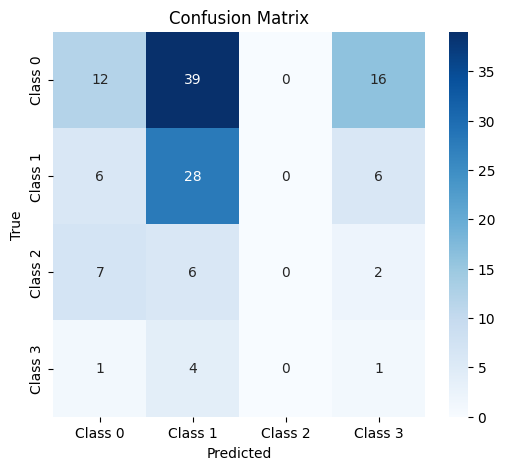

In [119]:
# Example usage after training
cm = evaluate_model(model, test_loader, device)

# Optional: visualize confusion matrix with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]  # Adjust as needed
plot_confusion_matrix(cm, class_names)


In [120]:
data.shape  # (64, 160)


torch.Size([64, 160])

Tranformer_paper_based_model

In [124]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_with_cm(model, data_loader, device):
    """
    Evaluate the model on the given data_loader, 
    compute confusion matrix and classification report.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            # For single-label 4-class classification:
            # outputs is (batch_size, 4)
            _, predicted = torch.max(outputs, dim=1)  # (batch_size,)
            
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())
    
    # Flatten
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    
    # Classification report
    print("\nClassification Report:\n", 
          classification_report(all_labels, all_preds))
    
    return cm


In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class DEAPDataset(Dataset):
    def __init__(self, data, labels):
        """
        data: np.array of shape (num_samples, seq_len, n_channels)
        labels: np.array of shape (num_samples,)
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]      # (seq_len, n_channels)
        y = self.labels[idx]    # scalar or integer
        # Convert to torch
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y



class EEGTransformer(nn.Module):
    def __init__(self, input_dim=160, hidden_dim=128, num_classes=4, num_heads=8, num_layers=2):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, 160)
        # Add a dummy sequence dimension
        x = x.unsqueeze(1)      # -> (batch_size, 1, 160)

        # Project: (batch_size, 1, hidden_dim)
        x = self.input_projection(x)

        # Transformer expects (batch_size, seq_len, hidden_dim)
        x = self.transformer_encoder(x)   # -> (batch_size, 1, hidden_dim)

        # Mean-pool over seq_len (which is 1, so it's basically a squeeze)
        x = x.mean(dim=1)                 # -> (batch_size, hidden_dim)

        # Classification
        x = self.fc(x)                    # -> (batch_size, num_classes)
        return x

# ----------------------
# Main training snippet
# ----------------------
def train_transformer_deap(train_data, train_labels, val_data, val_labels, device):
    # Create datasets
    train_dataset = DEAPDataset(train_data, train_labels)
    val_dataset   = DEAPDataset(val_data, val_labels)
    
    train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader    = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = EEGTransformer(input_dim=160, hidden_dim=128, num_classes=4)
    batch_x = torch.randn(32, 160)  # e.g. one batch
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            criterion = nn.CrossEntropyLoss()

            outputs = model(batch_x)   # shape (B, 4), float
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total   += batch_y.size(0)
        
        train_loss = total_loss / len(train_loader)
        train_acc  = correct / total
        
        # Evaluate on validation set
        val_acc = evaluate_accuracy(model, val_loader, device)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")
    
    return model

# Evaluate with confusion matrix
def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total   += batch_y.size(0)
    return correct / total

model = train_transformer_deap(train_data, train_labels, val_data, val_labels, device)
cm = evaluate_model_with_cm(model, val_loader, device)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_29952/295438526.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_29952/295438526.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Epoch [1/20] Train Loss: 0.9848, Train Acc: 0.6445, Val Acc: 0.7266
Epoch [2/20] Train Loss: 0.8907, Train Acc: 0.6738, Val Acc: 0.7266
Epoch [3/20] Train Loss: 0.8745, Train Acc: 0.6777, Val Acc: 0.7266
Epoch [4/20] Train Loss: 0.8680, Train Acc: 0.6816, Val Acc: 0.7266
Epoch [5/20] Train Loss: 0.8652, Train Acc: 0.6670, Val Acc: 0.7266
Epoch [6/20] Train Loss: 0.8583, Train Acc: 0.6719, Val Acc: 0.7266
Epoch [7/20] Train Loss: 0.8577, Train Acc: 0.6787, Val Acc: 0.7266
Epoch [8/20] Train Loss: 0.8388, Train Acc: 0.6846, Val Acc: 0.7266
Epoch [9/20] Train Loss: 0.8346, Train Acc: 0.6826, Val Acc: 0.7266
Epoch [10/20] Train Loss: 0.8349, Train Acc: 0.6787, Val Acc: 0.7266
Epoch [11/20] Train Loss: 0.8391, Train Acc: 0.6846, Val Acc: 0.7266
Epoch [12/20] Train Loss: 0.8264, Train Acc: 0.6846, Val Acc: 0.7266
Epoch [13/20] Train Loss: 0.8259, Train Acc: 0.6768, Val Acc: 0.7266
Epoch [14/20] Train Loss: 0.8190, Train Acc: 0.6836, Val Acc: 0.7266
Epoch [15/20] Train Loss: 0.8108, Train Acc

/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Neuro-GPT

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPTPositionalEncoding(nn.Module):
    """Optional: learned or sinusoidal positional embeddings."""
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        # For simplicity, let's do a learnable embedding
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        We add a positional embedding for each time step.
        """
        batch_size, seq_len, d_model = x.shape
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # (1, seq_len)
        # Expand so it matches (batch_size, seq_len)
        positions = positions.expand(batch_size, seq_len)
        pos_emb = self.pe(positions)  # (batch_size, seq_len, d_model)
        return x + pos_emb

class GPTDecoderBlock(nn.Module):
    """A simplified GPT-like decoder block."""
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        
        self.mlp = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # x: (batch, seq_len, d_model)
        # Self-attention (causal if attn_mask is set)
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout(attn_out)
        x = self.ln1(x)

        # Feedforward
        mlp_out = self.mlp(x)
        x = x + self.dropout(mlp_out)
        x = self.ln2(x)
        return x

class NeuroGPT(nn.Module):
    """
    Simplified GPT-like model for EEG multiclass classification:
    1) Input projection
    2) Positional encoding
    3) Multiple decoder blocks
    4) Classification head
    """
    def __init__(
        self,
        input_dim=32,      # e.g., # of EEG channels or feature dim
        d_model=128,
        nhead=8,
        num_decoder_layers=4,
        num_classes=4,
        seq_len=128,
        dropout=0.1,
        use_causal_mask=False
    ):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.use_causal_mask = use_causal_mask

        # Project input_dim -> d_model
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding (optional, but often beneficial for sequences)
        self.pos_encoding = GPTPositionalEncoding(d_model, max_len=seq_len)

        # Stacked GPT-like decoder layers
        self.decoder_blocks = nn.ModuleList([
            GPTDecoderBlock(d_model, nhead, dim_feedforward=4*d_model, dropout=dropout)
            for _ in range(num_decoder_layers)
        ])

        # Classification head: we can pool over seq_len or take final token
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, input_dim)
        """
        # 1) Project to (batch, seq_len, d_model)
        x = self.input_projection(x)

        # 2) Optional positional encoding
        x = self.pos_encoding(x)  # (batch, seq_len, d_model)

        # 3) Build an attention mask if using causal approach
        attn_mask = None
        if self.use_causal_mask:
            # A lower-triangular mask: (seq_len, seq_len)
            attn_mask = torch.triu(
                torch.ones(self.seq_len, self.seq_len, device=x.device), diagonal=1
            )
            attn_mask = attn_mask.masked_fill(attn_mask==1, float('-inf'))

        # Pass through each decoder block
        for block in self.decoder_blocks:
            x = block(x, attn_mask=attn_mask)

        # 4) Pooling or final token for classification
        # Option A: mean-pool across time
        x = x.mean(dim=1)  # (batch_size, d_model)

        # Option B: take the last token (like GPT does)
        # x = x[:, -1, :]  # (batch_size, d_model)

        # Classification
        out = self.classifier(x)  # (batch_size, num_classes)
        return out


In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_neuro_gpt(train_loader, val_loader, device, epochs=10, lr=1e-4):
    # Instantiate the model
    model = NeuroGPT(
        input_dim=160,      # or however many features you have
        d_model=128,
        nhead=8,
        num_decoder_layers=4,
        num_classes=4,
        seq_len=50,         # or however many time steps
        dropout=0.1,
        use_causal_mask=False  # set True if you want strictly causal
    ).to(device)

    criterion = nn.CrossEntropyLoss()  # single-label 4-class
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)                # (batch, 4)
            loss = criterion(outputs, batch_y)       # batch_y in [0..3]
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        
        val_acc = evaluate_accuracy(model, val_loader, device)
        
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    return model

def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    return correct / total


In [135]:
# -------------------------------
# EXAMPLE USAGE / DEMO
# -------------------------------
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
seq_len = 50
input_dim = 160
num_classes = 4
num_samples = 1000


X = np.random.randn(num_samples, seq_len, input_dim)  # random features
y = np.random.randint(0, 4, size=(num_samples,))      # random labels [0..3]

# Convert to torch tensors
features_tensor = torch.tensor(X, dtype=torch.float32)
labels_tensor   = torch.tensor(y, dtype=torch.long)

# -------------------------------
# 2. Split into Train & Val
# -------------------------------
train_size = int(0.8 * num_samples)
val_size   = num_samples - train_size

train_data = features_tensor[:train_size]
train_labels = labels_tensor[:train_size]
val_data   = features_tensor[train_size:]
val_labels = labels_tensor[train_size:]

# Create DataLoader objects
train_dataset = TensorDataset(train_data, train_labels)
val_dataset   = TensorDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# -------------------------------
# 3. Train NeuroGPT
# -------------------------------
model = train_neuro_gpt(train_loader, val_loader, device, epochs=40, lr=1e-4)

# -------------------------------
# 4. Evaluate on Validation Set
# -------------------------------
val_acc = evaluate_accuracy(model, val_loader, device)
test_acc = evaluate_accuracy(model, test_loader, device)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}, {test_acc:4f}")


Using device: cpu
[Epoch 1/40] Loss: 1.3883, Train Acc: 0.2838, Val Acc: 0.2550
[Epoch 2/40] Loss: 1.3890, Train Acc: 0.2475, Val Acc: 0.2550
[Epoch 3/40] Loss: 1.3726, Train Acc: 0.3000, Val Acc: 0.2400
[Epoch 4/40] Loss: 1.3662, Train Acc: 0.3450, Val Acc: 0.2600
[Epoch 5/40] Loss: 1.3603, Train Acc: 0.3387, Val Acc: 0.2550
[Epoch 6/40] Loss: 1.3502, Train Acc: 0.3425, Val Acc: 0.2250
[Epoch 7/40] Loss: 1.3475, Train Acc: 0.3463, Val Acc: 0.2200
[Epoch 8/40] Loss: 1.3350, Train Acc: 0.3975, Val Acc: 0.2300
[Epoch 9/40] Loss: 1.3240, Train Acc: 0.3837, Val Acc: 0.2400
[Epoch 10/40] Loss: 1.3110, Train Acc: 0.4100, Val Acc: 0.2650
[Epoch 11/40] Loss: 1.2793, Train Acc: 0.4487, Val Acc: 0.2600
[Epoch 12/40] Loss: 1.2577, Train Acc: 0.4462, Val Acc: 0.2100
[Epoch 13/40] Loss: 1.2436, Train Acc: 0.4575, Val Acc: 0.2500
[Epoch 14/40] Loss: 1.2055, Train Acc: 0.4600, Val Acc: 0.2100
[Epoch 15/40] Loss: 1.1580, Train Acc: 0.5112, Val Acc: 0.2400
[Epoch 16/40] Loss: 1.1336, Train Acc: 0.5175,

ValueError: not enough values to unpack (expected 3, got 2)